In [131]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

print("\nADD data description")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov())
print("\nSample - ADD data")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].head())


ADD data preprocessing
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
Combined data set: (31188, 8)
type filtering(before):(31188, 8)
type filtering(after):(21210, 8)
Dataframe before add new terms: (21210, 8)
Dataframe after add constant feature: (21210, 18)
Iksan data: (21210, 18)

ADD data preprocessing
../data/PLdata_nonsan_wt_1399.csv: distance filtering(before):(114455, 4)
../data/PLdata_nonsan_wt_1399.csv: distance filtering(after):(14603, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(14603, 4)
../data/PLdata_nons

In [133]:
%autoreload

addDataSample = samplingData(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']], 0.1)
addDataSample.sort_values(by=['logDistance'])

manual_normalize = True

X = normalizeData(addDataSample[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']], scaler = 'standard', auto = not manual_normalize)
Y = np.array(addDataSample[['pathloss']])

data distribution(before)
       logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance     pathloss
count  79125.00000   79125.00000  79125.00000  79125.00000      79125.00000               79125.00000  79125.00000
mean       0.30807       3.03282      1.05325      0.30103         -0.32041                   0.32494    127.46660
std        0.11901       0.31582      0.15991      0.00000          0.32522                   0.13568     16.61257
min        0.00003       2.60206      0.84510      0.30103         -1.00000                   0.00004     85.05800
25%        0.23252       2.60206      0.84510      0.30103         -0.62342                   0.23656    114.90700
50%        0.32884       3.14582      1.17609      0.30103         -0.27300                   0.33415    127.16800
75%        0.39827       3.35199      1.17609      0.30103         -0.04899                   0.41372    140.50700
max        0.47708       3.35199      1.17609      0.3

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


normalization distribution(after):
       logDistance  logFrequency  logHeightB  logHeightM  logHeightTratio  logAntennaMulLogDistance
count   7912.00000    7912.00000  7912.00000  7912.00000       7912.00000                7912.00000
mean       0.30717       0.30357     0.10526     0.30103         -0.32282                   0.32389
std        0.11988       0.03143     0.01601     0.00000          0.32549                   0.13623
min        0.00010       0.26021     0.08451     0.30103         -1.00000                   0.00012
25%        0.23132       0.26021     0.08451     0.30103         -0.62893                   0.23535
50%        0.32894       0.31458     0.11761     0.30103         -0.27300                   0.33383
75%        0.39797       0.33520     0.11761     0.30103         -0.04899                   0.41235
max        0.47708       0.33520     0.11761     0.30103          0.40255                   0.56109


In [137]:
kf = KFold(n_splits=5, shuffle=False)
kf.get_n_splits(X)

modelList = []
dataSet = []
i = 1
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    model = ann_mlp_regression(X_train, y_train.flatten(), (60,60,60,), activation='logistic', optimizer='lbfgs')

#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)    
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/ann_model_' + str(i) + '.sav'
    pickle.dump(model, open(filename, 'wb'))
    i+=1

loss: 62.44107500707839
ANN-Model-1-train error(RMSE): 11.17473977431106
ANN-Model-1-test error(RMSE): 11.501334133155607
loss: 65.18435807355594
ANN-Model-2-train error(RMSE): 11.417537602693562
ANN-Model-2-test error(RMSE): 11.541511436383312
loss: 65.90867305144765
ANN-Model-3-train error(RMSE): 11.480642123838646
ANN-Model-3-test error(RMSE): 11.799761914387915
loss: 64.72140980729307
ANN-Model-4-train error(RMSE): 11.376683070944306
ANN-Model-4-test error(RMSE): 11.773592470842095
loss: 66.95807045874056
ANN-Model-5-train error(RMSE): 11.571867186206202
ANN-Model-5-test error(RMSE): 11.87845647487335


Group-  0.26Ghz Data shape:(2080, 7)
Group-  0.31Ghz Data shape:(2169, 7)
Group-  0.34Ghz Data shape:(2080, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


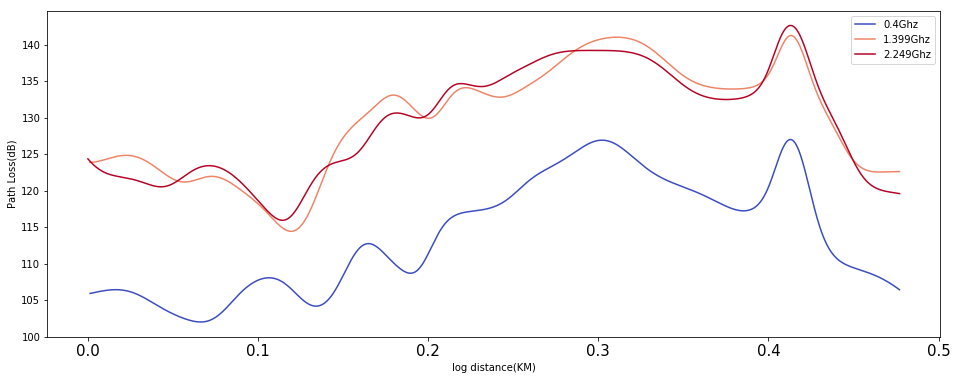

Group-  0.26Ghz Data shape:(2089, 7)
Group-  0.31Ghz Data shape:(2153, 7)
Group-  0.34Ghz Data shape:(2087, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


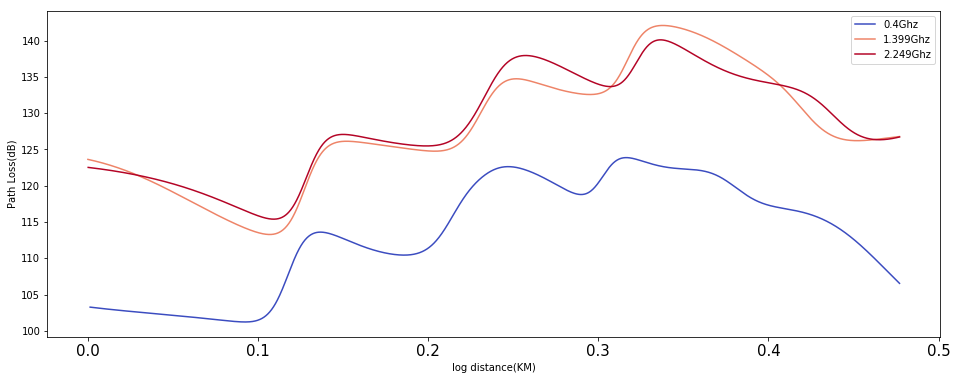

Group-  0.26Ghz Data shape:(2077, 7)
Group-  0.31Ghz Data shape:(2185, 7)
Group-  0.34Ghz Data shape:(2068, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


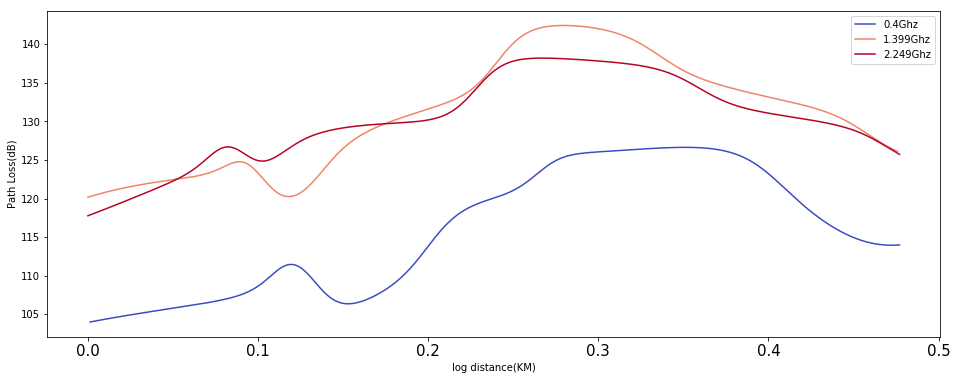

Group-  0.26Ghz Data shape:(2075, 7)
Group-  0.31Ghz Data shape:(2161, 7)
Group-  0.34Ghz Data shape:(2094, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


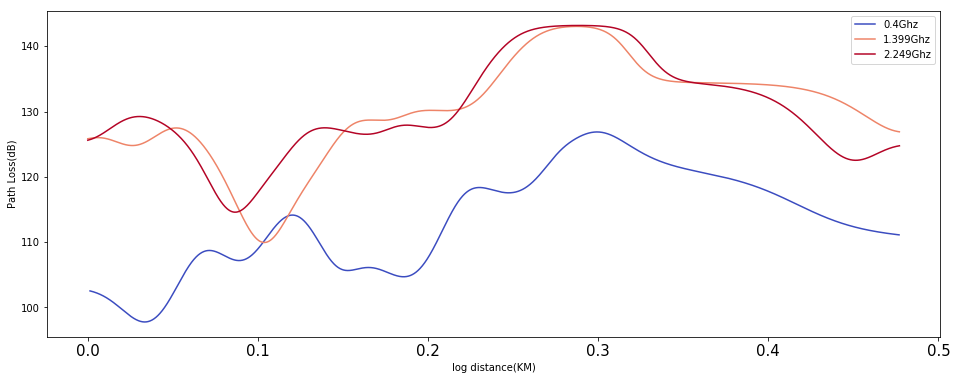

Group-  0.26Ghz Data shape:(2047, 7)
Group-  0.31Ghz Data shape:(2176, 7)
Group-  0.34Ghz Data shape:(2107, 7)
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56
For 'logDistance' column, min value:  0.00, max value:  0.48
For 'logAntennaMulLogDistance' column, min value:  0.00, max value:  0.56


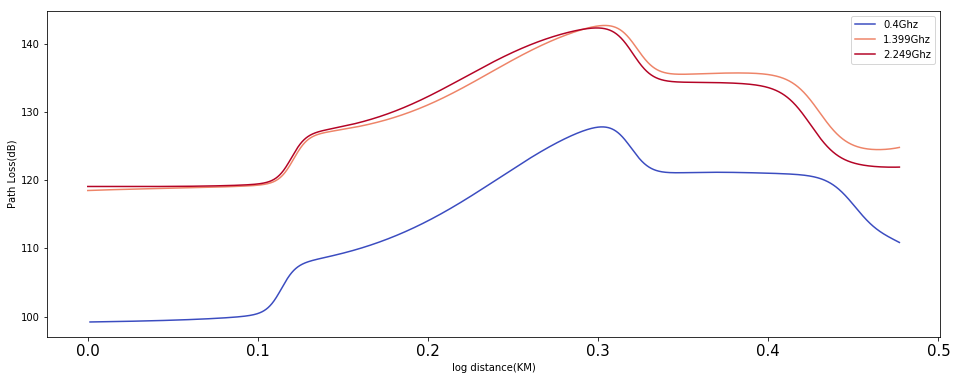

In [145]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM', 'logHeightTratio'])

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_2d_graph(model, graphX, graphY, ['logDistance', 'logAntennaMulLogDistance'])
    i+=1

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   10000.00000  10000.00000  10000.00000      1.00000e+04               10000.00000
mean       0.30813       0.29770      0.10524      0.30103     -3.23534e-01                   0.28061
std        0.00000       0.02187      0.00000      0.00000      5.55139e-17                   0.16357
min        0.30813       0.26021      0.10524      0.30103     -3.23534e-01                   0.00012
25%        0.30813       0.27895      0.10524      0.30103     -3.23534e-01                   0.14036
50%        0.30813       0.29770      0.10524      0.30103     -3.23534e-01                   0.28061
75%        0.30813       0.31645      0.10524      0.30103     -

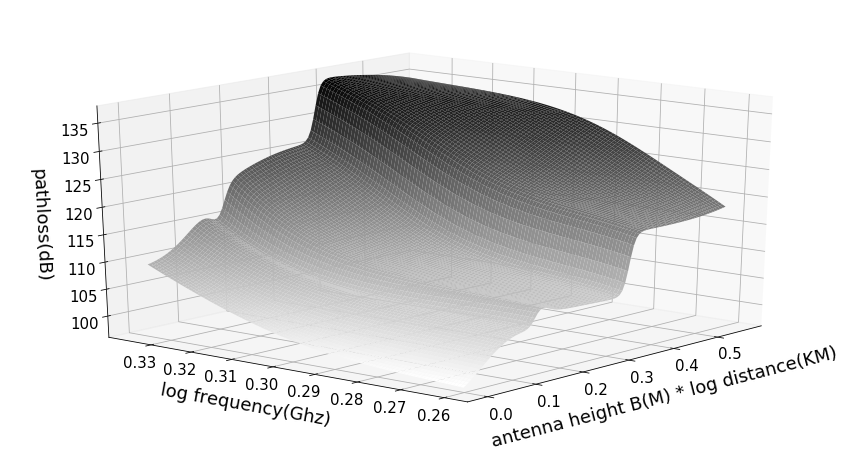

3D graph for log distance and log frequency - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  1.00000e+04  10000.00000      1.00000e+04               10000.00000
mean   3.07558e-01       0.29770  1.05371e-01      0.30103     -3.20587e-01                   0.28061
std    5.55139e-17       0.02187  1.38785e-17      0.00000      1.11028e-16                   0.16357
min    3.07558e-01       0.26021  1.05371e-01      0.30103     -3.20587e-01                   0.00012
25%    3.07558e-01       0.27895  1.05371e-01      0.30103     -3.20587e-01                   0.14036
50%    3.07558e-01       0.29770  1.05371e-01      0.30103     -3.20587e-01                   0.28061
75%    3.07558e-01       0.31645  1.05371e-01      0.30103     -

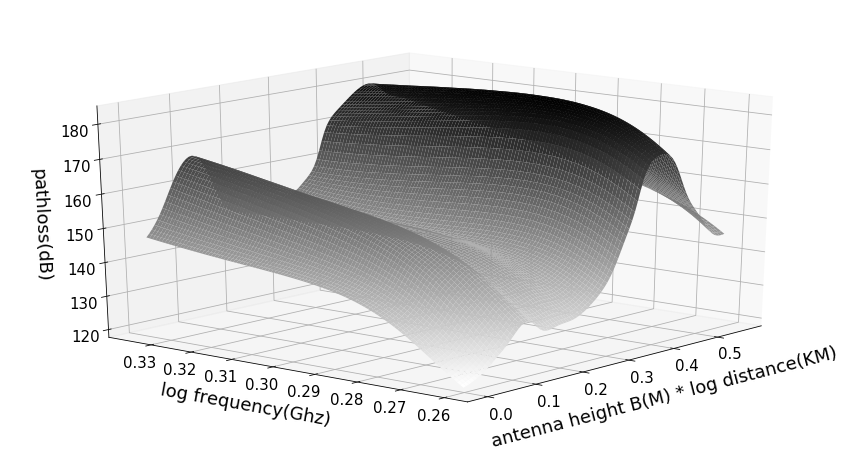

3D graph for log distance and log frequency - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  1.00000e+04  10000.00000      1.00000e+04               10000.00000
mean   3.07531e-01       0.29770  1.05180e-01      0.30103     -3.25505e-01                   0.28060
std    5.55139e-17       0.02187  1.38785e-17      0.00000      1.11028e-16                   0.16357
min    3.07531e-01       0.26021  1.05180e-01      0.30103     -3.25505e-01                   0.00012
25%    3.07531e-01       0.27895  1.05180e-01      0.30103     -3.25505e-01                   0.14036
50%    3.07531e-01       0.29770  1.05180e-01      0.30103     -3.25505e-01                   0.28060
75%    3.07531e-01       0.31645  1.05180e-01      0.30103     -

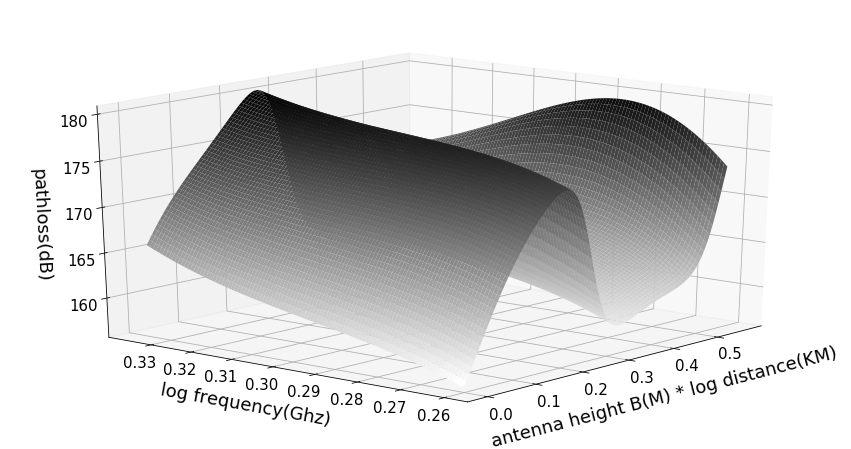

3D graph for log distance and log frequency - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count   10000.0000   10000.00000  1.00000e+04  10000.00000      1.00000e+04               10000.00000
mean        0.3065       0.29770  1.05253e-01      0.30103     -3.21562e-01                   0.28061
std         0.0000       0.02187  2.77570e-17      0.00000      5.55139e-17                   0.16357
min         0.3065       0.26021  1.05253e-01      0.30103     -3.21562e-01                   0.00012
25%         0.3065       0.27895  1.05253e-01      0.30103     -3.21562e-01                   0.14036
50%         0.3065       0.29770  1.05253e-01      0.30103     -3.21562e-01                   0.28061
75%         0.3065       0.31645  1.05253e-01      0.30103     -

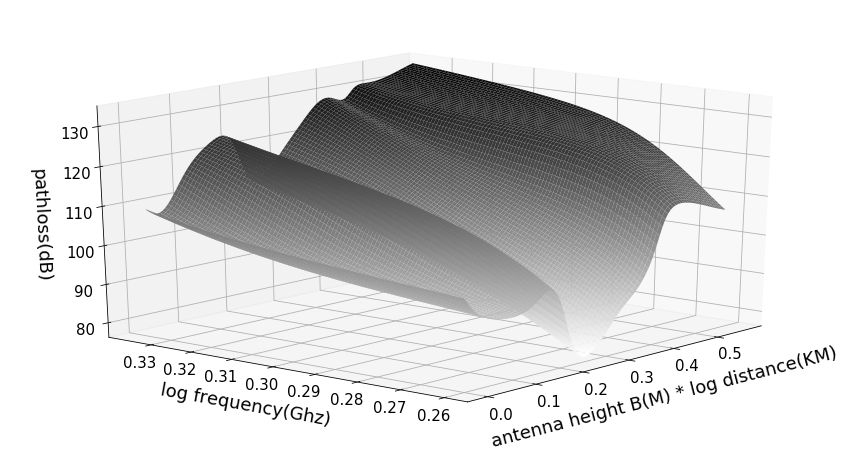

3D graph for log distance and log frequency - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  1.00000e+04  10000.00000      1.00000e+04               10000.00000
mean   3.06125e-01       0.29770  1.05237e-01      0.30103     -3.22922e-01                   0.28061
std    5.55139e-17       0.02187  1.38785e-17      0.00000      5.55139e-17                   0.16357
min    3.06125e-01       0.26021  1.05237e-01      0.30103     -3.22922e-01                   0.00012
25%    3.06125e-01       0.27895  1.05237e-01      0.30103     -3.22922e-01                   0.14036
50%    3.06125e-01       0.29770  1.05237e-01      0.30103     -3.22922e-01                   0.28061
75%    3.06125e-01       0.31645  1.05237e-01      0.30103     -

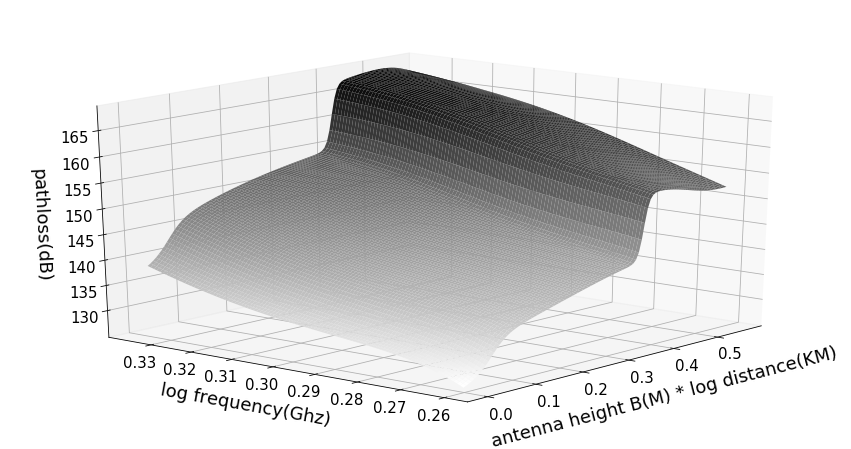

In [152]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log frequency - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logFrequency']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","log frequency(Ghz)","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height TB/TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  10000.00000  10000.00000      10000.00000               10000.00000
mean       0.30813   3.03487e-01      0.10524      0.30103         -0.29873                   0.28061
std        0.00000   1.11028e-16      0.00000      0.00000          0.40897                   0.16357
min        0.30813   3.03487e-01      0.10524      0.30103         -1.00000                   0.00012
25%        0.30813   3.03487e-01      0.10524      0.30103         -0.64936                   0.14036
50%        0.30813   3.03487e-01      0.10524      0.30103         -0.29873                   0.28061
75%        0.30813   3.03487e-01      0.10524  

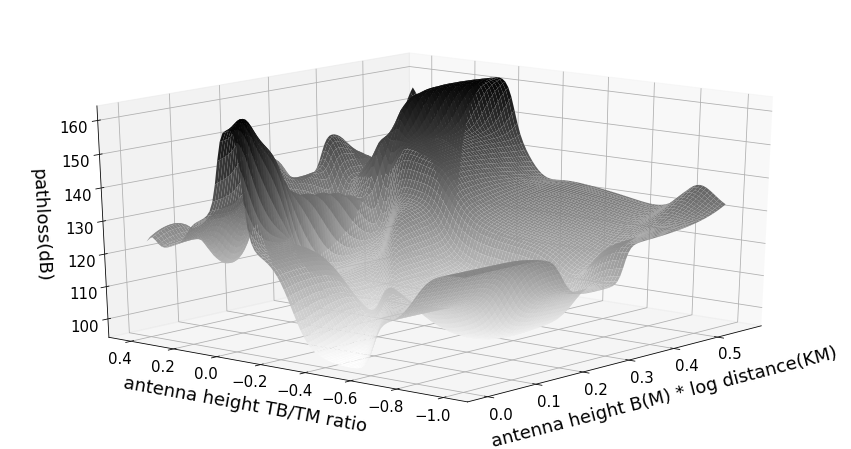

3D graph for log distance and log antenna height TB/TM ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  1.00000e+04  10000.00000      10000.00000               10000.00000
mean   3.07558e-01   3.03433e-01  1.05371e-01      0.30103         -0.29987                   0.28061
std    5.55139e-17   5.55139e-17  1.38785e-17      0.00000          0.40830                   0.16357
min    3.07558e-01   3.03433e-01  1.05371e-01      0.30103         -1.00000                   0.00012
25%    3.07558e-01   3.03433e-01  1.05371e-01      0.30103         -0.64994                   0.14036
50%    3.07558e-01   3.03433e-01  1.05371e-01      0.30103         -0.29987                   0.28061
75%    3.07558e-01   3.03433e-01  1.05371e-01  

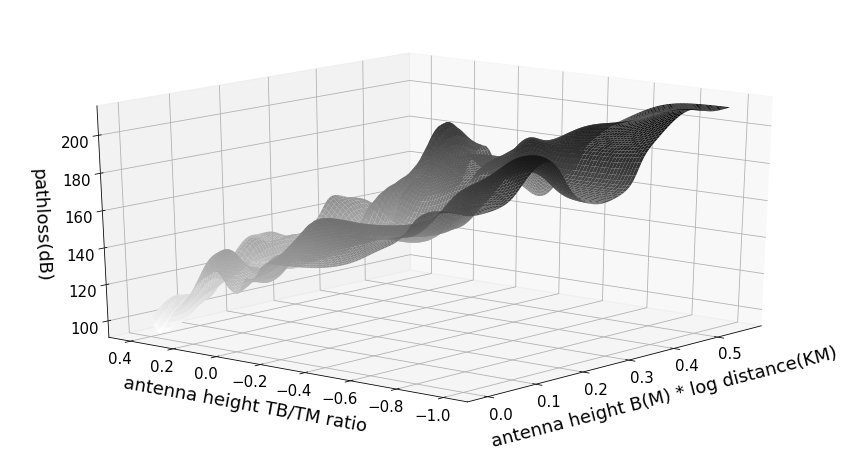

3D graph for log distance and log antenna height TB/TM ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  1.00000e+04  10000.00000      10000.00000               10000.00000
mean   3.07531e-01   3.03476e-01  1.05180e-01      0.30103         -0.29873                   0.28060
std    5.55139e-17   1.11028e-16  1.38785e-17      0.00000          0.40897                   0.16357
min    3.07531e-01   3.03476e-01  1.05180e-01      0.30103         -1.00000                   0.00012
25%    3.07531e-01   3.03476e-01  1.05180e-01      0.30103         -0.64936                   0.14036
50%    3.07531e-01   3.03476e-01  1.05180e-01      0.30103         -0.29873                   0.28060
75%    3.07531e-01   3.03476e-01  1.05180e-01  

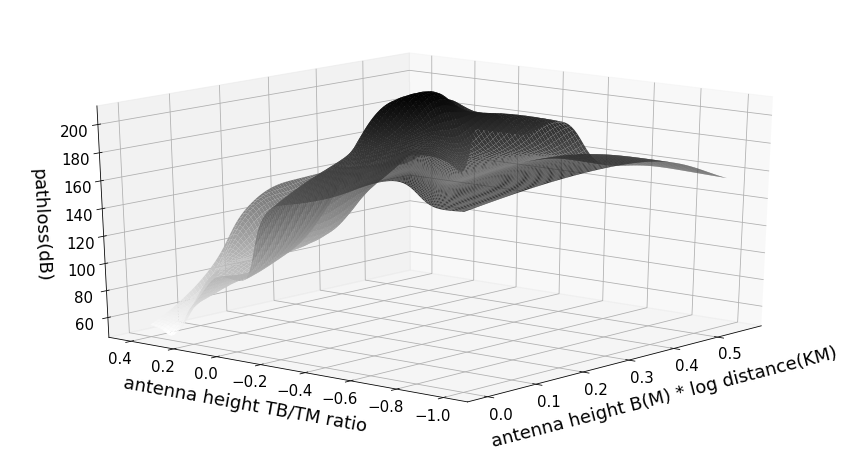

3D graph for log distance and log antenna height TB/TM ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count   10000.0000   10000.00000  1.00000e+04  10000.00000      10000.00000               10000.00000
mean        0.3065       0.30358  1.05253e-01      0.30103         -0.29873                   0.28061
std         0.0000       0.00000  2.77570e-17      0.00000          0.40897                   0.16357
min         0.3065       0.30358  1.05253e-01      0.30103         -1.00000                   0.00012
25%         0.3065       0.30358  1.05253e-01      0.30103         -0.64936                   0.14036
50%         0.3065       0.30358  1.05253e-01      0.30103         -0.29873                   0.28061
75%         0.3065       0.30358  1.05253e-01  

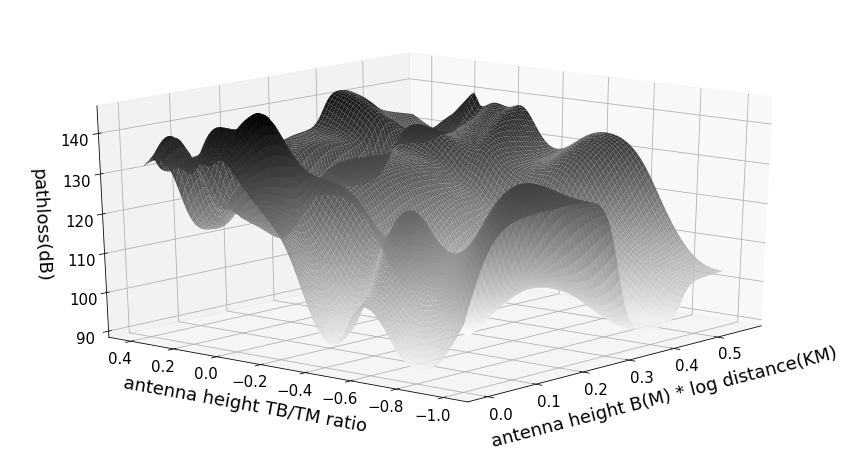

3D graph for log distance and log antenna height TB/TM ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  1.00000e+04  10000.00000      10000.00000               10000.00000
mean   3.06125e-01       0.30386  1.05237e-01      0.30103         -0.29873                   0.28061
std    5.55139e-17       0.00000  1.38785e-17      0.00000          0.40897                   0.16357
min    3.06125e-01       0.30386  1.05237e-01      0.30103         -1.00000                   0.00012
25%    3.06125e-01       0.30386  1.05237e-01      0.30103         -0.64936                   0.14036
50%    3.06125e-01       0.30386  1.05237e-01      0.30103         -0.29873                   0.28061
75%    3.06125e-01       0.30386  1.05237e-01  

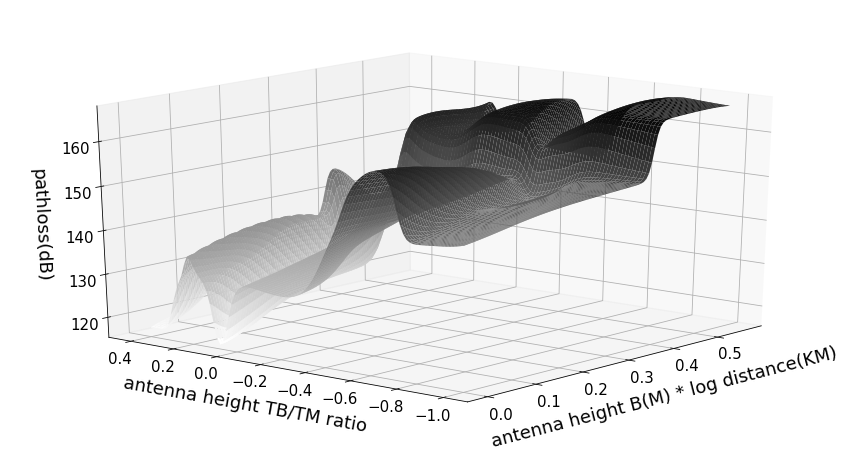

In [153]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height TB/TM ratio - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logHeightTratio']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height TB/TM ratio","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  10000.00000   1.00000e+04  10000.00000  10000.00000      1.00000e+04               10000.00000
mean       0.30813   3.03487e-01      0.10106      0.30103     -3.23534e-01                   0.28061
std        0.00000   1.11028e-16      0.00965      0.00000      5.55139e-17                   0.16357
min        0.30813   3.03487e-01      0.08451      0.30103     -3.23534e-01                   0.00012
25%        0.30813   3.03487e-01      0.09278      0.30103     -3.23534e-01                   0.14036
50%        0.30813   3.03487e-01      0.10106      0.30103     -3.23534e-01                   0.28061
75%        0.30813   3.03487e-01      0.10933      

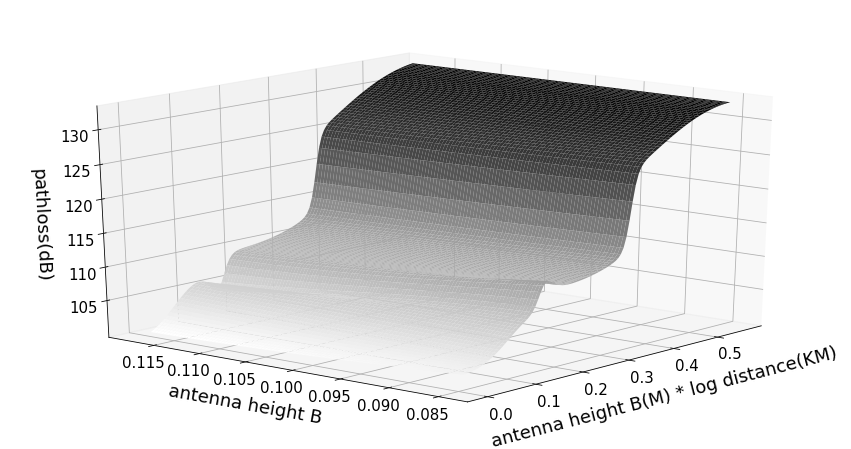

3D graph for log distance and log antenna height B ratio - trainset #2
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  10000.00000  10000.00000      1.00000e+04               10000.00000
mean   3.07558e-01   3.03433e-01      0.10106      0.30103     -3.20587e-01                   0.28061
std    5.55139e-17   5.55139e-17      0.00965      0.00000      1.11028e-16                   0.16357
min    3.07558e-01   3.03433e-01      0.08451      0.30103     -3.20587e-01                   0.00012
25%    3.07558e-01   3.03433e-01      0.09278      0.30103     -3.20587e-01                   0.14036
50%    3.07558e-01   3.03433e-01      0.10106      0.30103     -3.20587e-01                   0.28061
75%    3.07558e-01   3.03433e-01      0.10933      

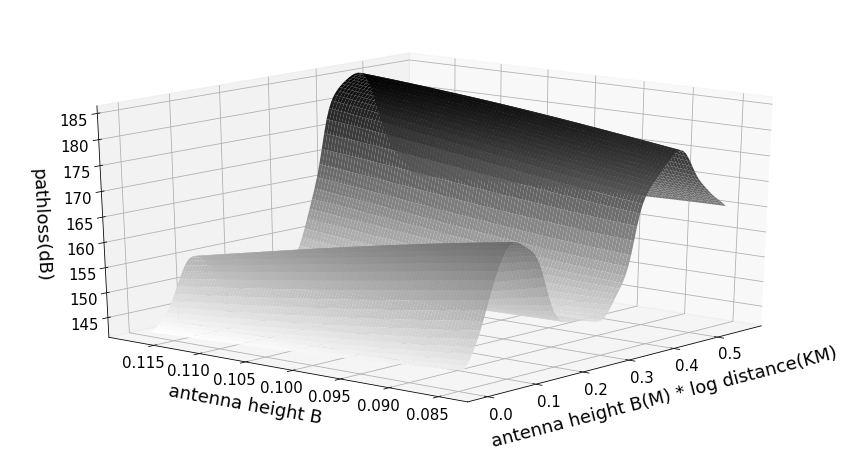

3D graph for log distance and log antenna height B ratio - trainset #3
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   1.00000e+04  10000.00000  10000.00000      1.00000e+04               10000.00000
mean   3.07531e-01   3.03476e-01      0.10106      0.30103     -3.25505e-01                   0.28060
std    5.55139e-17   1.11028e-16      0.00965      0.00000      1.11028e-16                   0.16357
min    3.07531e-01   3.03476e-01      0.08451      0.30103     -3.25505e-01                   0.00012
25%    3.07531e-01   3.03476e-01      0.09278      0.30103     -3.25505e-01                   0.14036
50%    3.07531e-01   3.03476e-01      0.10106      0.30103     -3.25505e-01                   0.28060
75%    3.07531e-01   3.03476e-01      0.10933      

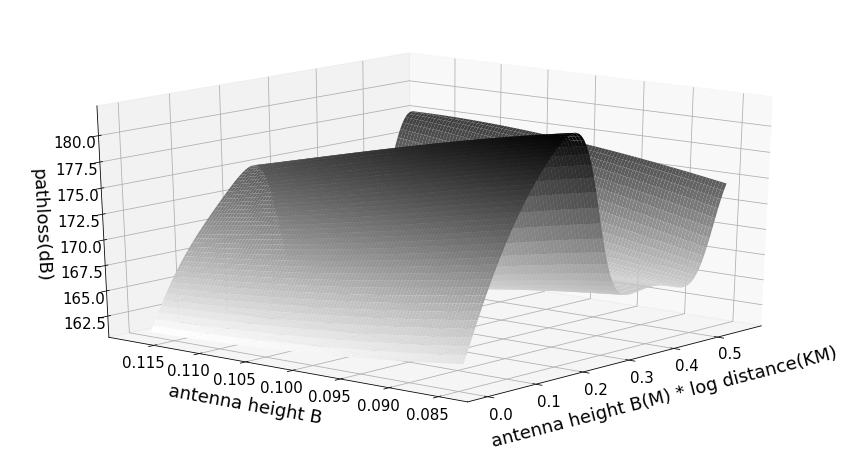

3D graph for log distance and log antenna height B ratio - trainset #4
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count   10000.0000   10000.00000  10000.00000  10000.00000      1.00000e+04               10000.00000
mean        0.3065       0.30358      0.10106      0.30103     -3.21562e-01                   0.28061
std         0.0000       0.00000      0.00965      0.00000      5.55139e-17                   0.16357
min         0.3065       0.30358      0.08451      0.30103     -3.21562e-01                   0.00012
25%         0.3065       0.30358      0.09278      0.30103     -3.21562e-01                   0.14036
50%         0.3065       0.30358      0.10106      0.30103     -3.21562e-01                   0.28061
75%         0.3065       0.30358      0.10933      

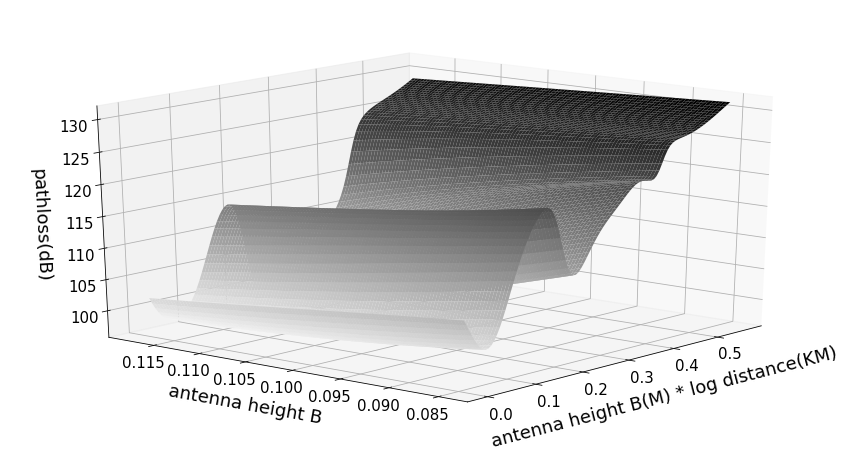

3D graph for log distance and log antenna height B ratio - trainset #5
Index(['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance
count  1.00000e+04   10000.00000  10000.00000  10000.00000      1.00000e+04               10000.00000
mean   3.06125e-01       0.30386      0.10106      0.30103     -3.22922e-01                   0.28061
std    5.55139e-17       0.00000      0.00965      0.00000      5.55139e-17                   0.16357
min    3.06125e-01       0.30386      0.08451      0.30103     -3.22922e-01                   0.00012
25%    3.06125e-01       0.30386      0.09278      0.30103     -3.22922e-01                   0.14036
50%    3.06125e-01       0.30386      0.10106      0.30103     -3.22922e-01                   0.28061
75%    3.06125e-01       0.30386      0.10933      

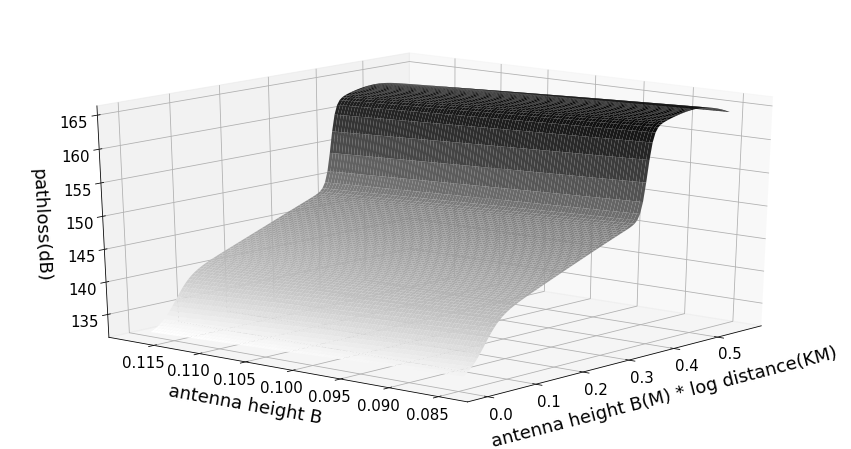

In [154]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
    targetCols = ['logAntennaMulLogDistance', 'logHeightB']
    xLabel,yLabel,zLabel = "antenna height B(M) * log distance(KM)","antenna height B","pathloss(dB)"
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), targetCols)

    model = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)
    i+=1

Equation Derivation for trainset #1
Group-  0.26Ghz Data shape:(2080, 7)
Group-  0.31Ghz Data shape:(2169, 7)
Group-  0.34Ghz Data shape:(2080, 7)
ANN-Model-1-train error(RMSE): 11.17473977431106
ANN-Model-1-test error(RMSE): 11.501334133155607
MultiLinear-1-train error(RMSE): 12.857227229317052
MultiLinear-1-test error(RMSE): 12.933744602448265

Objective Function with manual normalization data
L_pathloss = (-86.57 + 110.68log_hb)log_d + 2664.83log_f + -3723.18log_hb +  -0.00log_hm +  16.01log_(h_tb/h_tm) +  81.56
RMSE(ANN-MultiLinear): 6.350989293183693


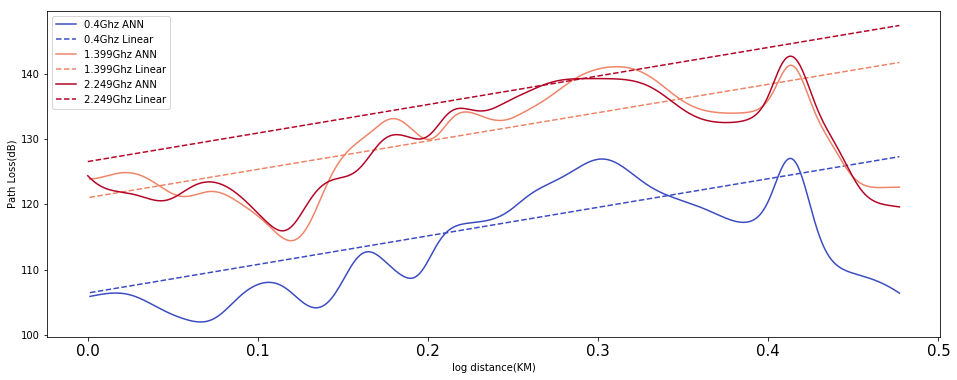

Equation Derivation for trainset #2
Group-  0.26Ghz Data shape:(2089, 7)
Group-  0.31Ghz Data shape:(2153, 7)
Group-  0.34Ghz Data shape:(2087, 7)
ANN-Model-2-train error(RMSE): 11.417537602693562
ANN-Model-2-test error(RMSE): 11.541511436383312
MultiLinear-2-train error(RMSE): 12.891992297990253
MultiLinear-2-test error(RMSE): 12.801092206527885

Objective Function with manual normalization data
L_pathloss = (-70.66 +  96.01log_hb)log_d + 2745.75log_f + -3110.41log_hb +   0.00log_hm +  15.25log_(h_tb/h_tm) +  72.26
RMSE(ANN-MultiLinear): 6.010013110837682


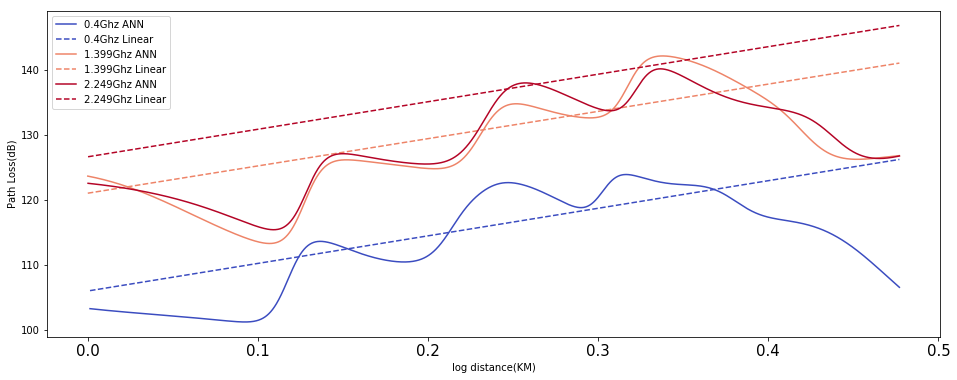

Equation Derivation for trainset #3
Group-  0.26Ghz Data shape:(2077, 7)
Group-  0.31Ghz Data shape:(2185, 7)
Group-  0.34Ghz Data shape:(2068, 7)
ANN-Model-3-train error(RMSE): 11.480642123838646
ANN-Model-3-test error(RMSE): 11.799761914387915
MultiLinear-3-train error(RMSE): 12.844541521195454
MultiLinear-3-test error(RMSE): 12.984052862608655

Objective Function with manual normalization data
L_pathloss = (-82.98 + 107.59log_hb)log_d + 2687.54log_f + -3476.22log_hb +   0.00log_hm +  15.89log_(h_tb/h_tm) +  78.23
RMSE(ANN-MultiLinear): 5.716214565566322


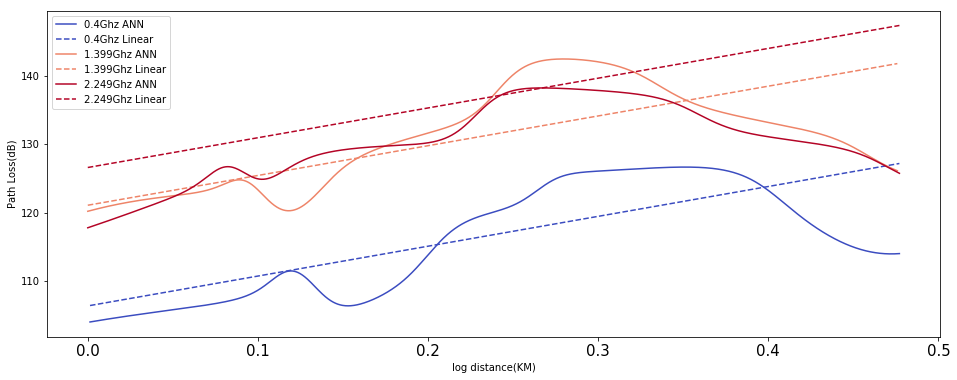

Equation Derivation for trainset #4
Group-  0.26Ghz Data shape:(2075, 7)
Group-  0.31Ghz Data shape:(2161, 7)
Group-  0.34Ghz Data shape:(2094, 7)
ANN-Model-4-train error(RMSE): 11.376683070944306
ANN-Model-4-test error(RMSE): 11.773592470842095
MultiLinear-4-train error(RMSE): 12.884280808854946
MultiLinear-4-test error(RMSE): 12.82153358871874

Objective Function with manual normalization data
L_pathloss = (-79.22 + 103.53log_hb)log_d + 2737.05log_f + -3513.47log_hb +   0.00log_hm +  16.27log_(h_tb/h_tm) +  77.39
RMSE(ANN-MultiLinear): 5.907497010660205


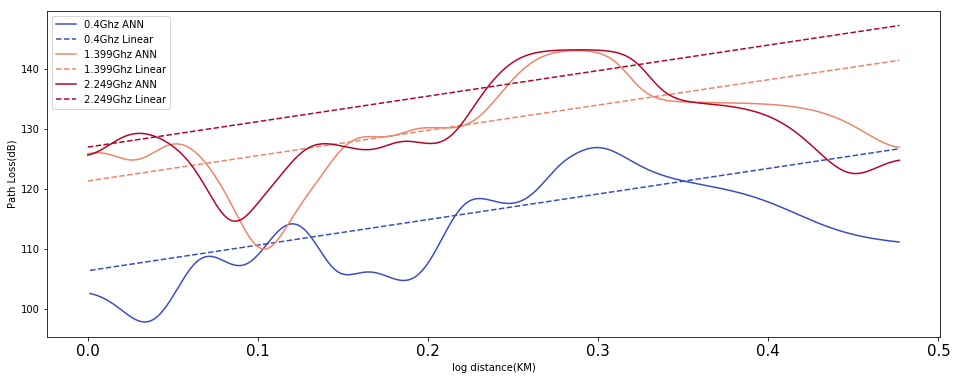

Equation Derivation for trainset #5
Group-  0.26Ghz Data shape:(2047, 7)
Group-  0.31Ghz Data shape:(2176, 7)
Group-  0.34Ghz Data shape:(2107, 7)
ANN-Model-5-train error(RMSE): 11.571867186206202
ANN-Model-5-test error(RMSE): 11.87845647487335
MultiLinear-5-train error(RMSE): 12.87431196071142
MultiLinear-5-test error(RMSE): 12.88639684048918

Objective Function with manual normalization data
L_pathloss = (-65.68 +  92.99log_hb)log_d + 2684.69log_f + -3377.84log_hb +   0.00log_hm +  16.83log_(h_tb/h_tm) +  76.99
RMSE(ANN-MultiLinear): 5.683414013621905


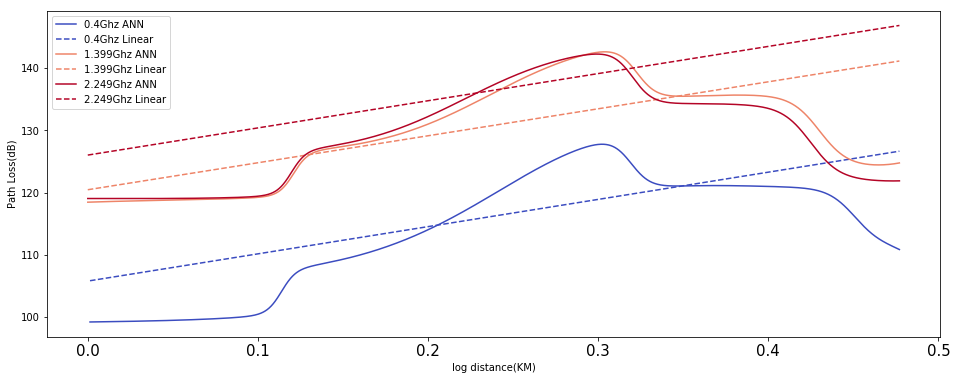

In [147]:
%autoreload
i = 1
for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("="*120)
    print("Equation Derivation for trainset #{}".format(i))
    data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']), ['logHeightB', 'logHeightM', 'logHeightTratio'])

    ANNmodel = pickle.load(open("model/ann_model_"+ str(i) +".sav", 'rb'))
    ANNPred = ANNmodel.predict(X_train)
    
    linearModel = Ridge(alpha=0.001).fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("ANN-Model-"+str(i)+"-test error(RMSE):", testError)  
    print("MultiLinear-"+str(i)+"-train error(RMSE):",RMSE_LIN_TRAIN)
    print("MultiLinear-"+str(i)+"-test error(RMSE):",RMSE_LIN_TEST)
    
    if manual_normalize:
        print("\nObjective Function with manual normalization data")
        print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
              .format(linearModel.coef_[0],linearModel.coef_[5],linearModel.coef_[1]*10,\
                      linearModel.coef_[2]*10,linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_))    
    else:
        print("L_pathloss = ({:6.2f} + {:6.2f}log_hb)log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb/h_tm) + {:6.2f}"\
              .format(linearModel.coef_[0],linearModel.coef_[5],linearModel.coef_[1],\
                      linearModel.coef_[2],linearModel.coef_[3],linearModel.coef_[4],linearModel.intercept_))

    print("RMSE(ANN-MultiLinear):", RMSE_LIN_ANN)
    graphX = data[0]
    graphY = data[1]
    ann_linear_compare_graph(ANNmodel, linearModel, graphX, graphY)

    i+=1